$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\dmu}{d \mu}
\newcommand{\dmup}{d \mu'}
\newcommand{\vf}{{\bf f}}
\newcommand{\vq}{{\bf q}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mK}{{\bf K}}
$

In [4]:
include("nda_note.jl")

# Using the notebook

The first cell in this notebook is an invisible markdown cell with LaTeX commands. The second is a code cell that sets up the packages you'll need to load. It's best to do a __run all__ before experimenting with the solvers.

## Contents

[The equation and discretization](#The-Equation)

[GMRES and Source Iteration](#Testing-simple-solvers)

[NDA Formulation](#NDA)

[References](ndaqmc.html)

# The equation

This note book compares various solvers for the problem in the Garcia/Siewert 
paper <cite data-cite="cesinh"><a href="ndaqmc.html#cesinh">(GS82)</cite>.  My formulation of the transport problem is taken from <cite data-cite="ctk:jeff1"><a href="ndaqmc.html#ctk:jeff1">(WKKP13b)</cite>. The equation for the angular flux $\psi$ is 

$$
\mu \frac{\partial \psi}{\partial x} (x,\mu) + \Sigma_t(x) \psi(x,\mu) =
\frac{1}{2} \left[ \Sigma_s(x) \int_{-1}^1 \psi(x, \mu') \dmup + q(x) \right]
 \mbox{ for } 0 \le x \le \tau
$$

The boundary conditions are

$$
\psi(0, \mu) = \psi_l(\mu), \mu > 0; \psi(\tau, \mu) = \psi_r(\mu),
\mu < 0.
$$
    
The notation is
    
   - $\psi$ is intensity of radiation or angular flux at point $x$ at angle $\cos^{-1} (\mu)$
   - $\phi = \phi(x) = \int_{-1}^{1}\psi(x,\mu) \ d\mu$ is the scalar flux, the $0^{th}$ angular moment of the angular flux.
    - $\tau < \infty$, length of the spatial domain.
    - $\Sigma_s \in C([0,\tau])$ is the scattering cross section at $x$
    - $\Sigma_t \in C([0,\tau])$ is the total cross section at $x$
    - $\psi_l$ and $\psi_r$ are incoming intensities at the bounds
    - $q \in C([0,\tau])$ is the fixed source
    
## Discretization    

The discretization is plain vanilla $S_N$ with diamond differencing. I'm storing fluxes (and later currents) at cell edges to make the boundary conditions for NDA a bit easier to deal with.

I'm using double Gaussian quadratures for the angular mesh. 
This means that the angles are N-point Gaussian quadratures on (-1,0) and on (0,1) for a total of 2N angles. The function __sn_angles.jl__ in the /src directory sets up the angular mesh. It uses the package __FastGaussQuadrature.jl__. We will denote the weights and notes of the angluar mesh by $w_j$ and $\mu_j$ for $j=1, ..., 2N$.

I'm using a uniform spatial mesh $\{ x_i \}_{i=1}^{N_x}$ where
$$
x_i = (i -1) dx \mbox{ and } dx = \tau/(N_x - 1).
$$
The function __sn_init.jl__ in /src sets up all the mesh data and boundary conditions. It builds a Julia named tuple for me to pass around to the solvers.

The disretization approximates the angular flux $\psi_i^j \approx \psi(x_i, \mu_j)$ and the scalar flux 
$$
\phi_i \approx \phi(x_i).
$$
The two approximations are related (in my cell-edge oriented code) by
$$
\mbox{Flux Equation:        } \phi_i =  \sum_{j=1}^{2N} \psi_i^j w_j 
$$

The discrete equation is, with source $S_i = \Sigma_s(x_i) f_i + q(s_i)$

$$
\begin{array}{ll}
\mbox{Transport Sweep:}
\\
\mu_j \frac{\psi_i^j - \psi_{i-1}^j}{dx} + \Sigma_t(x_i+dx/2) \frac{\psi_i^j + \psi_{i-1}^j}{2}
& = \frac{S_i + S_{i-1}}{2}
\mbox{ for $\mu_j > 0$ and $\psi_1^j = \psi(0,\mu_j)$}
\\
\mu_j \frac{\psi_i^j - \psi_{i+1}^j}{dx} + \frac{\psi_i^j + \psi_{i+1}^j}{2}
& = \frac{S_i + S_{i+1}}{2}
 \mbox{ for $\mu_j < 0$ and $\psi_{N_x}^j = \psi(\tau,\mu_j)$}
\end{array}
$$

So, source iteration begins with an initial iterate for the scalar flux $\phi$, computes the discrete scalar flux with the equations __Transport_Sweep__, treating $\vf$ as input data, and updates the scalar flux 
with the formula __Flux_Equation__. This can also be viewed as a linear equation for $\phi$
$$
\phi - \mK  \phi = f
$$
and solved with a Krylov method like GMRES. The right side of the integral equation depends on the source $q$ and the boundary data.

## The Garcia-Siewert Example

In this example
$$
\tau=5, \Sigma_s(x) =\omega_0 e^{-x/s},  \Sigma_t(x) = 1, q(x) = 0, \psi_l(\mu) = 1, \psi_r(\mu) = 0.
$$

## Testing simple solvers

The function 
```compare.jl``` in the \src directory runs the source iteration and GMRES, plots the residual histories, and tabulates the exit disbributions for comparision with Tables 1 and 2 in the paper. As a sanity check I print the $L^\infty$ norm of the differences in the results from the two solvers. 

The next step is NDA and I think I can get Ryan's QMC code to talk to the NDA solver pretty readily.

Here is a run for the first columns in the tables. 

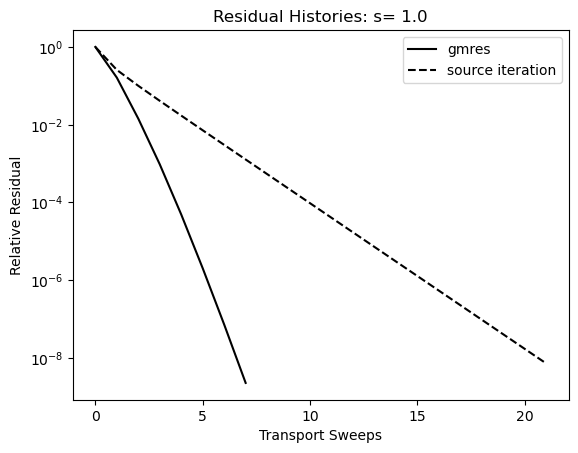

 mu         I(0,-mu)        I(tau,mu) 
 0.05     5.89670e-01     6.07486e-06 
 0.10     5.31120e-01     6.92514e-06 
 0.20     4.43280e-01     9.64229e-06 
 0.30     3.80307e-01     1.62338e-05 
 0.40     3.32965e-01     4.38575e-05 
 0.50     2.96091e-01     1.69371e-04 
 0.60     2.66564e-01     5.73462e-04 
 0.70     2.42390e-01     1.51281e-03 
 0.80     2.22235e-01     3.24369e-03 
 0.90     2.05175e-01     5.96035e-03 
 1.00     1.90547e-01     9.77122e-03 
Norm of result difference = 9.32897e-09


In [5]:
compare(1.0)

The functions all use precomputed data for the angles, spatial mesh, storage allocationf the angular flux, and various problem paramaters. The precomputed data lives in a named tuple ```sn_data``` which I create with ```ns_init.jl```. 

The iterations themselves use a transport sweep to do both source iteration and the liner residual computation for GMRES. In both cases a function ```flux_map!``` takes an input flux, does the transport sweep, and then takes the zeroth moment to return and output flux. The transport sweep is ```transport_sweep.jl``` it computes the angular flux from a given input flux and boundary conditions. 

Here is function for the source iteration solver. It's pretty simple if you believe ```flux_map.jl``` does what I say it does. I think the QMC version of ```flux_map.jl``` would fit in with this pretty easiliy. 

```
"""
 source_iteration(sn_data,s,tol)
 Source iteration example script for transport equation.

 This is one of the test cases from

 Radiative transfer in finite inhomogeneous plane-parallel atmospheres
 by Garcia and Siewert
 JQSRT (27), 1982 pp 141-148.

"""
function source_iteration(sn_data,s,tol=1.e-8)
    nx = 2001
    #
    # precomputed data
    #
    angles=sn_data.angles
    weihts=sn_data.weights
    itt = 0
    delflux = 1
    phi = zeros(nx)
    flux = zeros(nx)
    reshist = []
    while itt < 200 && delflux > tol
        flux = flux_map!(flux, sn_data)
        delflux = norm(flux - phi, Inf)
        itt = itt + 1
        push!(reshist, delflux)
        phi .= flux
    end
    #
    # Tabulate the exit distributions to check results.
    #
    return ( flux = flux, history= reshist)
end

```

Here are the results for the final column.

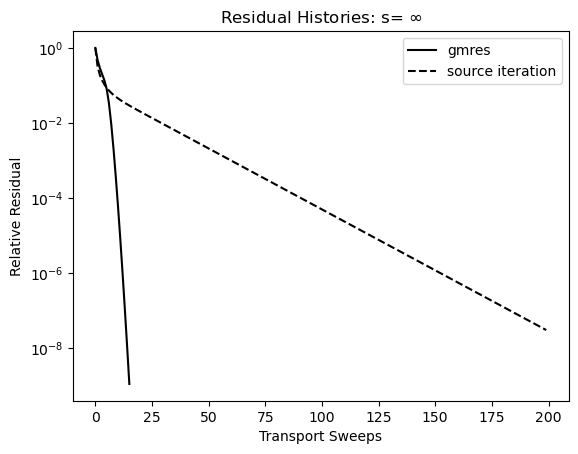

 mu         I(0,-mu)        I(tau,mu) 
 0.05     8.97799e-01     1.02201e-01 
 0.10     8.87836e-01     1.12164e-01 
 0.20     8.69581e-01     1.30419e-01 
 0.30     8.52299e-01     1.47701e-01 
 0.40     8.35503e-01     1.64497e-01 
 0.50     8.18996e-01     1.81004e-01 
 0.60     8.02676e-01     1.97324e-01 
 0.70     7.86493e-01     2.13507e-01 
 0.80     7.70429e-01     2.29571e-01 
 0.90     7.54496e-01     2.45504e-01 
 1.00     7.38721e-01     2.61279e-01 
Norm of result difference = 3.97115e-07


In [6]:
compare(Inf)

## NDA


NDA (nonlinear diffusion acceleration) turns the linear problem into a nonlinear one. One gets an equation for the (__low-order__) flux $f$ in terms of the moments of $\psi$. It is easier for me to explain this for the continuous problem. Be warned that my __boundary conditions are not standard__.

I'm taking this from 
<cite data-cite="ctk:jeff1"><a href="ndaqmc.html#ctk:jeff1">(WKKP13b)</cite>,
<cite data-cite="knollnda"><a href="ndaqmc.html#knollnda">(KPS11)</cite>, and
<cite data-cite="knoll08"><a href="ndaqmc.html#knoll08">(KPS08)</cite>.


Given a flux $\phi(x)$ we begin by solving a __high-order__ problem for an angular flux

$$
\mu \frac{\partial \psi^{HO}}{\partial x} + \Sigma_t\psi^{HO}(x,\mu)
= \frac{1}{2}\left[\Sigma_s \phi^{LO}(x) + q(x)\right],
$$
with the same boundary conditions we used in the original problem.

The next step is to compute high-order fluxes
$$
f^{HO}(x)= \int_{-1}^1 \psi(x, \mu') \dmu'
$$
and currents
$$
J^{HO}(x)= \int_{-1}^1 \psi(x, \mu') \mu' \dmu'.
$$

We use these to compute 
$$
{\hat D} = \frac{ J^{HO} + \frac{1}{3} \frac{d \phi^{HO}}{dx} } {\phi^{HO}},
$$
If $\phi$ is the solution to the __low-order__ problem, 
$$
\frac{d}{dx}\left[ -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} + \hat{D} \phi\right] + (\Sigma_t - \Sigma_s)\phi = q,
$$
then $\phi$ is the scalar flux and we have solved the transport equation. The boundary conditions are tricky if we store fluxes and currents at cell centers. If we have cell edge fluxes, then boundary conditions
$$
\phi(0) = \phi^{HO}(0), \phi(\tau) = \phi^{HO}(\tau)
$$
work well.
    
The low-order prolbem is nonlinear because $\phi^{HO}$, $J^{HO}$ and $\hat D$ depends on $\phi$. We can make this explicit and that helps when it's time to write code. Write the nonlinear equation as $F(\phi) = 0$ where
$$
F (\phi) = \frac{d}{dx}\left[ -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} + \hat{D} \phi\right] + (\Sigma_t - \Sigma_s)\phi - q.
$$

We can solve this equation efficiently with Newton-GMRES if we have a good preconditioner. We use fast solver for the high-order term in the low-order equation. The preconditioner in 
<cite data-cite="ctk:jeff1"><a href="ndaqmc.html#ctk:jeff1">(WKKP13b)</cite>,
<cite data-cite="knollnda"><a href="ndaqmc.html#knollnda">(KPS11)</cite>, 
<cite data-cite="knoll08"><a href="ndaqmc.html#knoll08">(KPS08)</cite>, is a bit more complicated. 

We can also formulate the low-order prolbem as a fixed point problem by viewing the solution of the low-order problem $\phi^{LO}$ as a transformation of $\phi$. So given $\phi^{LO}$ compute the high-order flux, current, and ${\hat D} = {\hat D}(\phi^{LO})$. Then solve 
$$
\frac{d}{dx}\left[ -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} + \hat{D}(\phi^{LO}) \phi\right] + (\Sigma_t - \Sigma_s)\phi = q,
$$
For $\phi$. This is a __linear__ equation for $\phi$ because $\phi^{LO}$ is input. Express this as 
$$
\phi = G(\phi^{LO})
$$
We have solved the problem if $\phi=\phi^{LO}$. So a fixed point iteration is
$$
\phi_{n+1} = G(\phi_n).
$$


